<a href="https://colab.research.google.com/github/ilan2002/Aquaculture_monitoring_using_Machinelearning_ESP32/blob/main/Optical_Character_Recognition_(OCR)_using_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
dhruvildave_english_handwritten_characters_dataset_path = kagglehub.dataset_download('dhruvildave/english-handwritten-characters-dataset')
preatcher_standard_ocr_dataset_path = kagglehub.dataset_download('preatcher/standard-ocr-dataset')
harieh_ocr_dataset_path = kagglehub.dataset_download('harieh/ocr-dataset')

print('Data source import complete.')


100%|██████████| 46.2M/46.2M [00:03<00:00, 15.6MB/s]

Extracting files...


Data source import complete.


# **Introduction**
**This project is part of Deep Learning/Computer Vision projects in Benha Faculty of Computers and AI (BFCAI)**

*Optical Character Recognition (OCR) is one of the critical tasks of computer vision and Artificial Intelligence, due to variety of languages written, variety of fonts for the same languages. our task is to make OCR and text detection for `English` texts*

*- our used dataset is `OCR-Dataset` which contains more than `200000` images for alphanumeric characters in both upper and lowercase*
*- our target is to detect **LOWERCASE** characters only in the text which are used in the project*

> Dataset was generated using 3475 font styles available in Google Fonts. Each alphanumeric character (uppercase, lowercase and numerals) was generated in each font style and stored in a directory. Total dataset size: 2.1 lakh images for 62 classes [OCR-Dataset](https://www.kaggle.com/datasets/harieh/ocr-dataset/)

![](https://www.cheggindia.com/wp-content/uploads/2023/08/ocr-full-form.png)

## **Table of Content**
### *1. Importing Libraries*
### *2. Helper Functions & Hyperparameters*
### *3. Reading & preparing the dataset*
### *4. Modeling*
### *5. Evaluation & Comparison*
### *6. Post-processing*
### *7. Conclusion*

# 1) Importing Libraries

In [2]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D,
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

# 2) Helper Functions & Hyperparameters

- **This section to define all Helper functions through the notebook and any hyperparameters used later for training the models**

In [3]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-

    path: String -> the main folder directory that contains train/test folders

    ________________________________________________________________________________________________
    Return-

    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])

    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:

    path: String -> a directory of the image
    _____________________________________________________________
    Return:

    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:

    img: numpy.array of N-D

    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:

    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()

def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.h5',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [4]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

# 3) Reading & preparing the dataset

In [5]:
# Reading the dataset in dataframe
main_path = '/kaggle/input/ocr-dataset/dataset'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 85199


,image,label
0,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1241...,c
1,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3096...,c
2,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3184...,c
3,/kaggle/input/ocr-dataset/dataset/c_L/C_L_2981...,c
4,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1635...,c


In [6]:
df['label'].value_counts()

,count
label,
r,3284
e,3284
a,3281
m,3281
n,3281
q,3279
u,3278
i,3277
d,3277


## 3.1) Splitting the dataframe
- The dataframe is splitted to get 70% of the dataset for `training` , and 30% for `testing`
- The training set is splitted into `training` and `validation` to enhance the model training

In [7]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [8]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

## 3.2) Creating generators
- The `ImageDataGenerators` is used for data augmentation, the augmentation is required since the `OCR` can work with different brightness which is not included in the dataset.
- Also, it enhance the RAM usage.

In [9]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE,
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [10]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

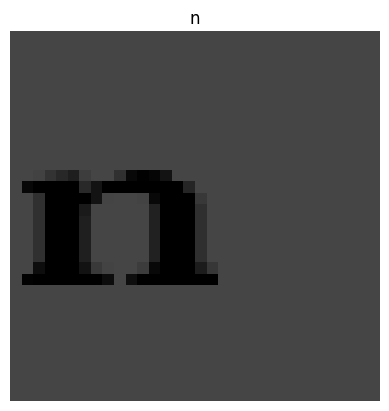

The shape of the image: (32, 32, 3)


In [13]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

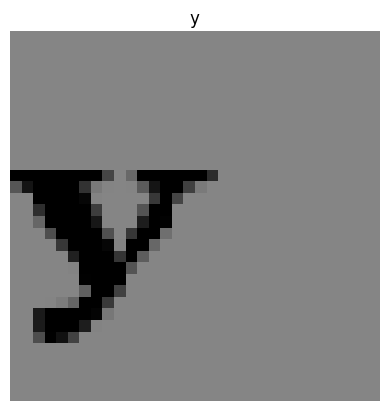

The shape of the image: (32, 32, 3)


In [17]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

# 4) Modeling
*Our target is to build a **`custom CNN model`** to train on our targeted images for the `OCR` application. in advance, we also will use 4 Pre-trained models as part of `Transfer Learning` and to enhance the performance of the application.*

***Our targeted pretrained models are the following:***

*- EfficientNetB7*

*- MobileNetV2*

*- VGG19*

*- DenseNet121*

***The fine-tuning strategy:*** *using a small value of `LR` of the optimizer `Adam` will make an efficient use of the pre-trained models on our dataset without **FREEZING** the input layers in which better performance is required in our case*

## 4.1) Custom CNN

In [18]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [19]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 32, 32, 3)             │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 30, 30, 128)           │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 10, 10, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 8, 8, 256)             │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 8, 8, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 4, 4, 256)             │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 2, 2, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 2, 2, 512)             │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 2, 2, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 2, 2, 1024)            │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 1, 1, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 1024)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1024)                  │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 26)                    │          26,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,243,502 (20.00 MB)

 Trainable params: 5,243,502 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [21]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.2304 - loss: 2.9479
Epoch 1: val_loss improved from inf to 1.04027, saving model to CustomCnn_model.h5


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 444s 311ms/step - accuracy: 0.2305 - loss: 2.9473 - val_accuracy: 0.6897 - val_loss: 1.0403 - learning_rate: 0.0010
Epoch 2/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6197 - loss: 1.2911
Epoch 2: val_loss improved from 1.04027 to 0.80461, saving model to CustomCnn_model.h5


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.6198 - loss: 1.2911 - val_accuracy: 0.7596 - val_loss: 0.8046 - learning_rate: 0.0010
Epoch 3/20
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7604 - loss: 0.8423
Epoch 3: val_loss improved from 0.80461 to 0.49362, saving model to CustomCnn_model.h5


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 75s 53ms/step - accuracy: 0.7604 - loss: 0.8422 - val_accuracy: 0.8655 - val_loss: 0.4936 - learning_rate: 0.0010
Epoch 4/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8380 - loss: 0.5780
Epoch 4: val_loss improved from 0.49362 to 0.46573, saving model to CustomCnn_model.h5


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.8381 - loss: 0.5780 - val_accuracy: 0.8864 - val_loss: 0.4657 - learning_rate: 0.0010
Epoch 5/20
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8633 - loss: 0.4970
Epoch 5: val_loss improved from 0.46573 to 0.38719, saving model to CustomCnn_model.h5


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 69s 50ms/step - accuracy: 0.8633 - loss: 0.4970 - val_accuracy: 0.9025 - val_loss: 0.3872 - learning_rate: 0.0010
Epoch 6/20
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8836 - loss: 0.4278
Epoch 6: val_loss improved from 0.38719 to 0.35797, saving model to CustomCnn_model.h5


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 78s 56ms/step - accuracy: 0.8836 - loss: 0.4278 - val_accuracy: 0.9054 - val_loss: 0.3580 - learning_rate: 0.0010
Epoch 7/20
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9003 - loss: 0.3634
Epoch 7: val_loss did not improve from 0.35797
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.9003 - loss: 0.3634 - val_accuracy: 0.9103 - val_loss: 0.3582 - learning_rate: 0.0010
Epoch 8/20
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9073 - loss: 0.3435
Epoch 8: val_loss did not improve from 0.35797
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.9073 - loss: 0.3435 - val_accuracy: 0.8942 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 9/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9112 - loss: 0.3319
Epoch 9: val_loss did not improve from 0.35797
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 76s 54ms/step - accuracy: 0.9112 - loss: 0.3319 - val_accuracy: 0.9104 - val_loss: 0.3699 - learning_rate: 0.0010
Epoch 10/20


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 77s 55ms/step - accuracy: 0.9144 - loss: 0.3228 - val_accuracy: 0.9199 - val_loss: 0.3562 - learning_rate: 0.0010
Epoch 11/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9172 - loss: 0.3165
Epoch 11: val_loss improved from 0.35621 to 0.31800, saving model to CustomCnn_model.h5


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 85s 57ms/step - accuracy: 0.9172 - loss: 0.3165 - val_accuracy: 0.9197 - val_loss: 0.3180 - learning_rate: 0.0010
Epoch 12/20
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9078 - loss: 0.3525
Epoch 12: val_loss did not improve from 0.31800
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 0.9078 - loss: 0.3525 - val_accuracy: 0.9227 - val_loss: 0.3301 - learning_rate: 0.0010
Epoch 13/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9226 - loss: 0.2868
Epoch 13: val_loss did not improve from 0.31800
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 77s 55ms/step - accuracy: 0.9226 - loss: 0.2868 - val_accuracy: 0.9209 - val_loss: 0.3712 - learning_rate: 0.0010
Epoch 14/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9195 - loss: 0.3070
Epoch 14: val_loss did not improve from 0.31800
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.9195 - loss: 0.3070 - val_accuracy: 0.9095 - val_loss: 0.4440 - learning_rate: 0.0010
Epoch 

1398/1398 ━━━━━━━━━━━━━━━━━━━━ 76s 54ms/step - accuracy: 0.9377 - loss: 0.2362 - val_accuracy: 0.9380 - val_loss: 0.2601 - learning_rate: 5.0000e-04
Epoch 18/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9523 - loss: 0.1690
Epoch 18: val_loss did not improve from 0.26008
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 77s 55ms/step - accuracy: 0.9523 - loss: 0.1690 - val_accuracy: 0.9435 - val_loss: 0.2800 - learning_rate: 5.0000e-04
Epoch 19/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9552 - loss: 0.1628
Epoch 19: val_loss did not improve from 0.26008
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 75s 54ms/step - accuracy: 0.9552 - loss: 0.1628 - val_accuracy: 0.9442 - val_loss: 0.2745 - learning_rate: 5.0000e-04
Epoch 20/20
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9548 - loss: 0.1622
Epoch 20: val_loss did not improve from 0.26008
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 70s 50ms/step - accuracy: 0.9548 - loss: 0.1622 - val_accuracy: 0.9482 - val_loss: 0.3067 - learning_rate: 5

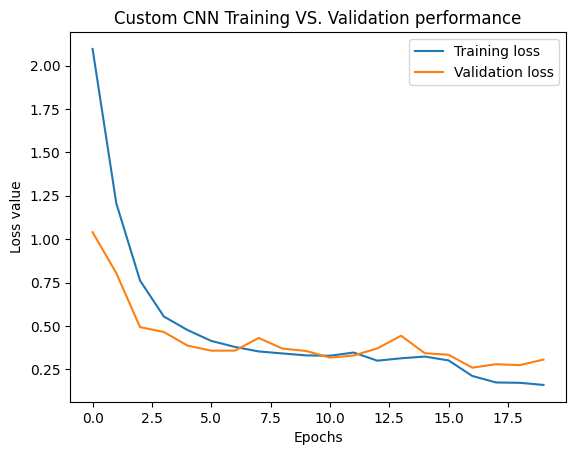

In [22]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [23]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 169s 212ms/step


In [24]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           a       0.95      0.93      0.94       992
           b       0.96      0.96      0.96       929
           c       0.95      0.93      0.94      1008
           d       0.97      0.95      0.96       999
           e       0.92      0.93      0.93       973
           f       0.98      0.93      0.95      1000
           g       0.95      0.93      0.94       957
           h       0.95      0.95      0.95       973
           i       0.94      0.94      0.94       969
           j       0.94      0.97      0.95       931
           k       0.94      0.96      0.95      1000
           l       0.92      0.94      0.93       974
           m       0.94      0.97      0.96      1005
           n       0.92      0.93      0.93       951
           o       0.93      0.95      0.94       951
           p       0.98      0.94      0.96       982
           q       0.95      0.94      0.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Install dependencies (if not installed)
!pip install opencv-python matplotlib tensorflow pytesseract

# Import necessary libraries
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
from google.colab import files

# Upload model and test image manually
uploaded = files.upload()  # Select 'CustomCnn_model.h5' and 'number_plate.jpg'

# Load the trained model
model = tf.keras.models.load_model("/content/CustomCnn_model.h5")  # Change to your uploaded model file

# Function to preprocess number plate image
def preprocess_image(image_path, target_size=(128, 128)):  # Adjust based on model input
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for better contrast
    image = cv2.resize(image, target_size)  # Resize to match model input
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=-1)  # Add channel dimension (grayscale)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Load and display the test image
def show_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Test Image Preview
image_path = "/content/drive/MyDrive/ocr/new/images.jpg"  # Change to your uploaded image
show_image(image_path)

# Run inference on the image
def predict_text(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)

    # Decode the model output
    predicted_class = np.argmax(prediction)  # Get the class index with the highest probability
    confidence = np.max(prediction)  # Get the confidence score

    return predicted_class, confidence

# Predict text from the uploaded image
predicted_class, confidence = predict_text(image_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")

# Optional: Apply OCR for further recognition
def apply_ocr(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    _, image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)  # Improve contrast
    text = pytesseract.image_to_string(image, config='--psm 8')  # OCR on the plate region
    return text

# Run OCR on the image
ocr_text = apply_ocr(image_path)
print("OCR Output:", ocr_text.strip())  # Strip unwanted spaces and newlines


KeyboardInterrupt: 

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


✅ YOLO and CNN Models Loaded Successfully!

image 1/1 /content/drive/MyDrive/ocr/new/Samples-of-Characters-for-Recognition-Sample-Indian-Vehicle-Sample-Foreign-Vehicle.png: 256x320 2 license_plates, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 320)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


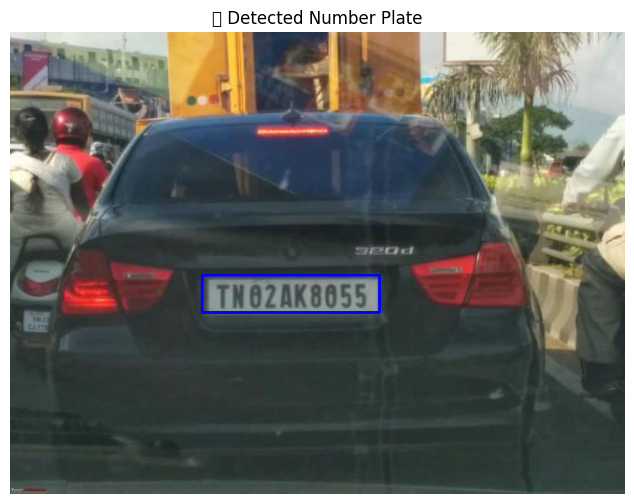

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


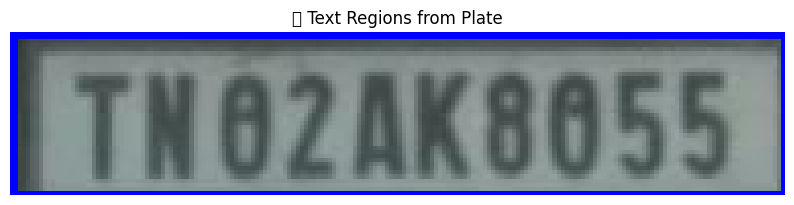

📌 Extracted Number Plate Text: 


In [3]:
# ✅ Install dependencies (run once in Colab)
!pip install opencv-python matplotlib tensorflow pytesseract ultralytics
!apt install tesseract-ocr -y

# ✅ Import libraries
import os
import cv2
import numpy as np
import tensorflow as tf
import pytesseract
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ✅ Define paths
YOLO_MODEL_PATH = "/content/best_dec.pt"  # Trained YOLOv8 model for number plate
CNN_MODEL_PATH = "/content/CustomCnn_model.h5"  # Your trained CNN model (optional)
IMAGE_PATH = "/content/drive/MyDrive/ocr/new/Samples-of-Characters-for-Recognition-Sample-Indian-Vehicle-Sample-Foreign-Vehicle.png"

# ✅ Load models
yolo_model = YOLO(YOLO_MODEL_PATH)
cnn_model = tf.keras.models.load_model(CNN_MODEL_PATH)
print("✅ YOLO and CNN Models Loaded Successfully!")

# ✅ Preprocess image for CNN
def preprocess_for_cnn(roi, target_size=(128, 128)):
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.resize(roi, target_size)
    roi = roi / 255.0
    roi = np.expand_dims(roi, axis=-1)
    roi = np.expand_dims(roi, axis=0)
    return roi

# ✅ Detect number plate using YOLO
def detect_number_plate(image_path):
    results = yolo_model.predict(image_path)
    image = cv2.imread(image_path)

    for result in results:
        for bbox in result.boxes:
            x1, y1, x2, y2 = map(int, bbox.xyxy[0])
            plate_img = image[y1:y2, x1:x2]
            return image, (x1, y1, x2, y2), plate_img

    return image, None, None

# ✅ Detect text regions using Tesseract OCR
def detect_text_regions(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    d = pytesseract.image_to_data(thresh, output_type=pytesseract.Output.DICT)

    text_regions = []
    for i in range(len(d["text"])):
        if int(d["conf"][i]) > 50:
            x, y, w, h = d["left"][i], d["top"][i], d["width"][i], d["height"][i]
            text_regions.append((x, y, w, h))

    return text_regions

# ✅ Extract text and visualize
def extract_and_visualize(image_path):
    image, plate_coords, plate_img = detect_number_plate(image_path)

    if plate_img is None:
        print("❌ No number plate detected.")
        return

    text_regions = detect_text_regions(plate_img)
    extracted_text = ""

    # Draw bounding box on original image
    x1, y1, x2, y2 = plate_coords
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Draw character boxes on plate
    for (x, y, w, h) in text_regions:
        roi = plate_img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config='--psm 7')
        extracted_text += text.strip() + " "

        # Optional CNN prediction (if you trained on individual characters)
        # processed = preprocess_for_cnn(roi)
        # prediction = cnn_model.predict(processed)
        # predicted_class = np.argmax(prediction)
        # print("CNN Predicted Class:", predicted_class)

        cv2.rectangle(plate_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Plot full image with plate box
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("🔍 Detected Number Plate")
    plt.axis("off")
    plt.show()

    # Plot cropped plate with text boxes
    plt.figure(figsize=(10, 4))
    plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
    plt.title("🧠 Text Regions from Plate")
    plt.axis("off")
    plt.show()

    print("📌 Extracted Number Plate Text:", extracted_text.strip())

# ✅ Run the full pipeline
extract_and_visualize(IMAGE_PATH)



image 1/1 /content/drive/MyDrive/ocr/new/download.jpg: 192x320 1 license_plate, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 192, 320)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


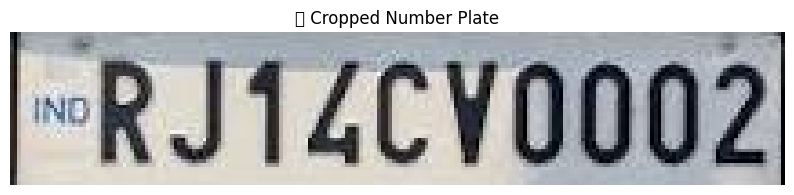

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-15-379ecd94b741>", line 131, in <cell line: 0>

  File "<ipython-input-15-379ecd94b741>", line 121, in run_pipeline

  File "<ipython-input-15-379ecd94b741>", line 98, in extract

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_3104]

In [15]:
# ✅ STEP 2: Install Required Packages
!pip install ultralytics
!pip install opencv-python-headless
!pip install matplotlib

import cv2
import numpy as np
import tensorflow as tf
from ultralytics import YOLO
import matplotlib.pyplot as plt

# ✅ STEP 3: Helper Function to Show Image
def show_image(img, title='Image'):
    plt.figure(figsize=(10, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# ✅ STEP 4: Your DenseNet Character Recognition Code
def load_model():
    model_path = '/content/CustomCnn_model.h5'  # ✅ Change path if needed
    model = tf.keras.models.load_model(model_path)
    return model

def convert_2_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def binarization(image):
    img, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words=False):
    img = image.copy()
    m = 3
    n = m - 2
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations=itrs)
    return dilation

def find_rect(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    sorted_rects = sorted(rects, key=lambda x: x[0])  # Sort left to right
    return sorted_rects

# ✅ Mapping index to character (Update if needed)
mapping_inverse = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5',
    6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F',
    16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L',
    22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
    28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X',
    34: 'Y', 35: 'Z'
}

def extract(image):
    model = load_model()
    chars = []

    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img, words=True)
    words = find_rect(full_dil_img)

    for word in words:
        x, y, w, h = word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)

        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

        for char in char_parts:
            cx, cy, cw, ch = char
            ch_img = img[cy:cy+ch, cx:cx+cw]

            empty_img = np.full((32, 32, 1), 255, dtype=np.uint8)
            resized = cv2.resize(ch_img, (16, 22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[3:3+22, 3:3+16, 0] = gray.copy()

            # Ensure the input image has 3 channels and is the correct data type
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0

            # Reshape to (1, 32, 32, 3) for the model input
            gray = gray.reshape(1, 32, 32, 3)

            # Remove extra dimension when calling predict
            predicted = mapping_inverse.get(np.argmax(model.predict(gray, verbose=0)), '?')
            chars.append(predicted)

        chars.append(' ')

    show_image(image, "OCR Result")
    return ''.join(chars).strip()

# ✅ STEP 5: YOLO + OCR Integration
def run_pipeline(image_path, yolo_model_path):
    image = cv2.imread(image_path)
    if image is None:
        print("❌ Could not load image.")
        return

    yolo = YOLO(yolo_model_path)
    results = yolo.predict(image_path)

    for result in results:
        for bbox in result.boxes:
            x1, y1, x2, y2 = map(int, bbox.xyxy[0])
            plate_crop = image[y1:y2, x1:x2]
            show_image(plate_crop, "🔍 Cropped Number Plate")
            print("🔠 Extracted Text:", extract(plate_crop))
            return

    print("❌ No number plate detected.")

# ✅ STEP 6: Run it!
IMAGE_PATH = "/content/drive/MyDrive/ocr/new/download.jpg"  # 🔁 Your test image
YOLO_MODEL_PATH = "/content/best_dec.pt"       # 🔁 Your YOLOv8 model

# ✅ Now RUN the pipeline!
run_pipeline(IMAGE_PATH, YOLO_MODEL_PATH)

## 4.2) EfficientNetB7

In [ ]:
# EfficientNetB7 input layers will not be FREEZED
train_layers = EfficientNetB7(include_top=False, input_shape=IMG_SIZE)
EffNetB7 = Sequential()
EffNetB7.add(train_layers)
EffNetB7.add(Flatten())
EffNetB7.add(Dense(1024, activation='selu'))
EffNetB7.add(Dropout(0.2))
EffNetB7.add(Dense(512, activation='selu'))
EffNetB7.add(Dense(len(mapping), activation='softmax'))

In [ ]:
EffNetB7.summary()

In [ ]:
# The pre-defined optimizer will be used with too small learning rate
EffNetB7.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history2 = EffNetB7.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck("EfficientNetB7"))

In [ ]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("EfficientNetB7 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the EfficientNetB7 for the testing set for the evaluation
prediction = EffNetB7.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The EfficientNetB7 Evaluation Performance')
print(classification_report(y_test, pred))

## 4.3) MobileNetV2

In [ ]:
# MobileNetV2 input layers will not be FREEZED
train_layers = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
MobNetV2 = Sequential()
MobNetV2.add(train_layers)
MobNetV2.add(Flatten())
MobNetV2.add(Dense(1024, activation='selu'))
MobNetV2.add(Dropout(0.2))
MobNetV2.add(Dense(512, activation='selu'))
MobNetV2.add(Dense(len(mapping), activation='softmax'))

In [ ]:
MobNetV2.summary()

In [ ]:
MobNetV2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history3 = MobNetV2.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck('MobileNetV2'))

In [ ]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobileNetV2 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the MobileNetV2 for the testing set for the evaluation
prediction = MobNetV2.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The MobileNetV2 Evaluation Performance')
print(classification_report(y_test, pred))

## 4.4) VGG19

In [ ]:
# VGG19 input layers will not be FREEZED
train_layers = VGG19(include_top=False, input_shape=IMG_SIZE)
VG = Sequential()
VG.add(train_layers)
VG.add(Flatten())
VG.add(Dense(1024, activation='selu'))
VG.add(Dense(512, activation='selu'))
VG.add(Dense(len(mapping), activation='softmax'))

In [ ]:
VG.summary()

In [ ]:
VG.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history4 = VG.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=clbck('VGG19'))

In [ ]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("VGG19 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the VGG19 for the testing set for the evaluation
prediction = VG.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe VGG19 Evaluation Performance')
print(classification_report(y_test, pred))

## 4.5) DenseNet121

In [ ]:
# DenseNset121 input layers will not be FREEZED
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

In [ ]:
Den.summary()

In [ ]:
Den.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=clbck("DenseNet121"))

In [ ]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

# 5) Evaluation & Comparison

In [ ]:
vals = {'accuracy':[0.95,0.93,0.71,0.96,0.95], 'precision':[0.96,0.94,0.72,0.96,0.95],
       'recall':[0.95,0.93,0.71,0.96,0.95], 'F1-Score':[0.95,0.93,0.71,0.96,0.95]}
results = pd.DataFrame(vals, index=['Custom CNN','EfficientNetB7','MobileNetV7','VGG19',
                                   'DenseNet121'])

print("\t\tThe Evaluation results of CNN/Pre-trained models")
print(results)

In [ ]:
sns.barplot(data=results, x=results.index, y='accuracy')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Accuracy")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='precision')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Precision")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='recall')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Recall")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='F1-Score')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models F1-Score")
plt.show()

**- `VGG19` shows an outstanding performance amongst all models.**

**- Due technical reasons in the next section `Post-processing`, it shows that `DenseNet121` has better performance than `VGG19` on external images, which will be used.**

**- The `Custom CNN` shows an excellent performance on the testing set on few number of epochs, it can be enhanced with more epochs and maybe data augmentation**

# 6) Post-Processing
#### **THIS SECTION IS ABOUT `Computer Vision` TECHNIQUES**

*the image will be taken from the user/externally to be processed and input into our model. some **LOW LEVEL COMPUTER VISION TECHNIQUES** are used in order to enhance the input image, wheter it is text or handwritten, these techniques are the following:*

- **Binarization:** The binarization function applies Otsu's binarization to the grayscale image, producing a binary image.

- **Dilate:** The dilate function performs morphological dilation on the binary image. The degree of dilation is adjusted based on whether processing `words` or `characters`.

- **Find Rectangles:** The find_rect function identifies bounding rectangles in the binary image, sorting them based on their **x-coordinate (From Left-to-Right)**.

- **Extract Characters:** The extract function uses the aforementioned techniques to extract characters from the image. It identifies words **FIRST**, then extracts characters from each word, and with the use of the pre-trained deep learning model to recognize each character.

In [ ]:
# Computer Vision - Low level techniques
def load_model():
    model_path = '/kaggle/working/DenseNet121_model.h5'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])

    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters

    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image
    del _, bin_img, full_dil_img                          # for better memory usage

    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word

        del _, bin_img, dil_img

        for char in char_parts:
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]

            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)

            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list

            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space

    del model
    show_image(image)
    return ''.join(chars[:-1])

## 6.1) Testing

In [25]:
# Testing 1
img = read_image('/kaggle/input/myimage16/Screenshot 2023-12-19 024132.png')
text = extract(img)
print('-->',text)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
# Testing 2
img2 = read_image('/kaggle/input/myimage15/Screenshot 2023-12-19 023610.png')
text = extract(img2)
print('-->',text)

In [ ]:
# Testing 3
img3 = read_image('/kaggle/input/myimage12/Screenshot 2023-12-19 021326.png')
text = extract(img3)
print('-->',text)

In [ ]:
# Testing 4
img4 = read_image('/kaggle/input/myimage8/Screenshot 2023-12-19 011000.png')
text = extract(img4)
print('-->',text)

# 7) Conclusion
*This OCR implementation combines low-level computer vision techniques with deep learning for character recognition. The functions provided can be customized or extended for specific use cases, making it a versatile tool for text extraction from images.*

# END OF THE NOTEBOOK